In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

sns.set_style('whitegrid')
sns.set_palette('Blues')
np.random.seed(427)

Populating the interactive namespace from numpy and matplotlib


WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/hadrian/.local/share/virtualenvs/Bantay-Krimen-Analysis-RDt4h6uW/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('../data/processed/crime_incidences.csv')
df = df[df.region == 'NCR']

In [3]:
df.head()

,crime,crimetype,customdate,customtime,date,date_com,datechar,lat,lng,location,modus,moduscode,province,region,station,time,hour
117484,ANTI-CARNAPPING ACT (R.A. 6539) MC,366,"Fri - May 12, 2017",1:25:AM,2017-05-12,2017-05-12,42867,14.6361,121.066,"Loyola Heights, Quirino, Quezon City, NCR",Forcibly Taken,mc87,Quezon City,NCR,Police Station 09 Quirino,01:25:00,1
117485,HOMICIDE,3,"Fri - May 12, 2017",12:10:AM,2017-05-12,2017-05-12,42867,14.5958,121.097,"Manggahan, City of Pasig, Ncr District 2 (East...",Shooting,mc37,Ncr District 2 (Eastern),NCR,Police Station 02 Pasig City,00:10:00,0
117486,Vehicular Traffic Accident,123,"Fri - May 12, 2017",8:04:AM,2017-05-12,2017-05-12,42867,14.5789,121.055,"Wack-Wack Greenhills, City of Mandaluyong, Ncr...",Not Indicated,mc00,Ncr District 2 (Eastern),NCR,Police Station 03 Mandaluyong City,08:04:00,8
117487,HOMICIDE,3,"Fri - May 12, 2017",2:05:AM,2017-05-12,2017-05-12,42867,14.5329,121.076,"Calzada, Taguig, Ncr District 4 (Southern), NCR",Shooting,mc37,Ncr District 4 (Southern),NCR,Police Station 07 Taguig,02:05:00,2
117488,Vehicular Traffic Accident,123,"Fri - May 12, 2017",8:04:AM,2017-05-12,2017-05-12,42867,14.5812,121.054,"Wack-Wack Greenhills, City of Mandaluyong, Ncr...",Not Indicated,mc00,Ncr District 2 (Eastern),NCR,Police Station 03 Mandaluyong City,08:04:00,8


Text(0.5,1,'Did the crime incidences change over time?')

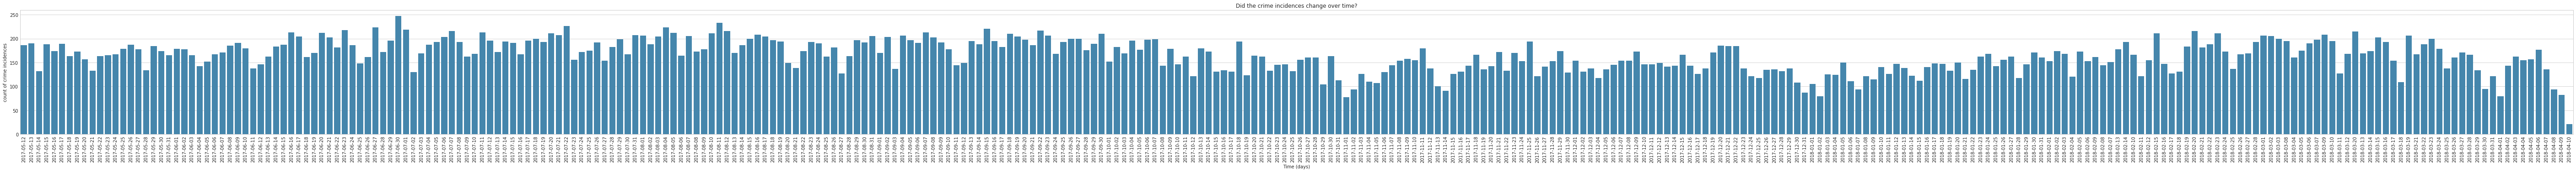

In [4]:
figsize(100, 5)
g = sns.countplot(x=df.date, color='#348ABD')
x = g.set_xticklabels(g.get_xticklabels(), rotation=90)
xlabel('Time (days)')
ylabel('count of crime incidences')
title('Did the crime incidences change over time?')

## All crime incidences

In [5]:
count_data = df.groupby('date')['crime'].count()

In [6]:
with pm.Model() as model:
    alpha = 1.0/count_data.mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(count_data) - 1)
    idx = np.arange(len(count_data))
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [7]:
with model:
    step = pm.NUTS()
    trace = pm.sample(35000, tune=5000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2_log__, lambda_1_log__]
>Metropolis: [tau]
 32%|███▏      | 12902/40000 [00:08<00:17, 1567.40it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '30226' (I am process '30227')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/hadrian/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '30226' (I am process '30228')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/hadrian/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.5-64/lock_dir
 71%|███████   | 28432/40000 [00:17<00:07, 1631.34it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '30227' (I am process '30228')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/hadrian/.theano/compiledir_Linux-4.13--generic-x86

In [8]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

/home/hadrian/.local/share/virtualenvs/Bantay-Krimen-Analysis-RDt4h6uW/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\lambda_2$ value')

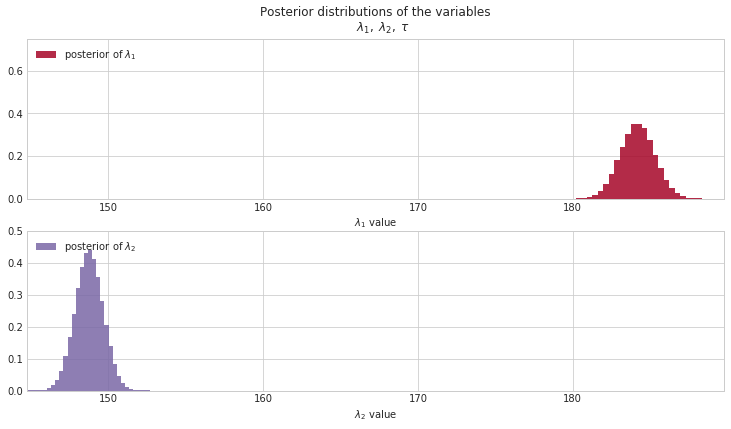

In [9]:
figsize(12.5, 10)
#histogram of the samples:
xlim = [min(lambda_1_samples.min(), lambda_2_samples.min()), max(lambda_1_samples.max(), lambda_2_samples.max())]
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(xlim)
plt.ylim([0, .75])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim(xlim)
plt.ylim([0, .5])
plt.xlabel("$\lambda_2$ value")

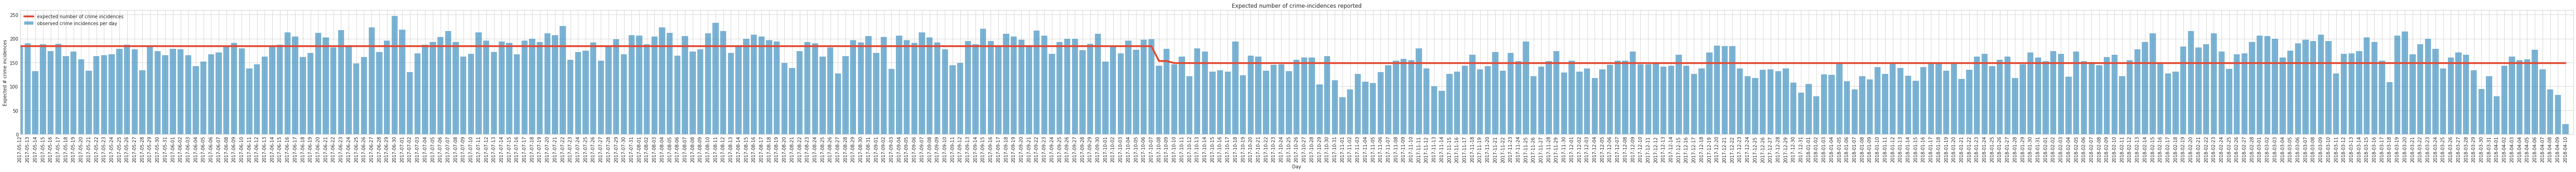

In [10]:
figsize(100, 5)
n_count_data = len(count_data)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_crime_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "crime incidence count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "crime incidence count".
    expected_crime_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_crime_per_day, lw=4, color="#E24A33",
         label="expected number of crime incidences")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # crime incidences")
plt.title("Expected number of crime-incidences reported")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed crime incidences per day")
plt.xticks(np.arange(len(count_data)), count_data.index, rotation='vertical')
plt.legend(loc="upper left");

In [11]:
print(f'% Decrease of crime: {1 - (lambda_2_samples / lambda_1_samples).mean()}')

% Decrease of crime: 0.19225310862072764


In [12]:
def by_crime_type(crime_type):
    count_data = df[df.crime == crime_type].groupby('date')['crime'].count()
    print('Creating model..')
    with pm.Model() as model:
        alpha = 1.0/count_data.mean()
        lambda_1 = pm.Exponential('lambda_1', alpha)
        lambda_2 = pm.Exponential('lambda_2', alpha)
        tau = pm.DiscreteUniform('tau', lower=0, upper=len(count_data) - 1)
        idx = np.arange(len(count_data))
        lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
        observation = pm.Poisson('obs', lambda_, observed=count_data)
    print('Running MCMC..')
    with model:
        step = pm.NUTS()
        trace = pm.sample(35000, tune=5000,step=step)
    lambda_1_samples = trace['lambda_1']
    lambda_2_samples = trace['lambda_2']
    tau_samples = trace['tau']
    print(f'% Decrease of crime: {1 - (lambda_2_samples / lambda_1_samples).mean()}')
    return (lambda_1_samples, lambda_2_samples, tau_samples, count_data, n_count_data)

## Homicide Incidences

In [13]:
lambda_1_samples, lambda_2_samples, tau_samples, count_data, n_count_data = by_crime_type('HOMICIDE')

Creating model..
Running MCMC..


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2_log__, lambda_1_log__]
>Metropolis: [tau]
100%|██████████| 40000/40000 [00:39<00:00, 1020.07it/s]
There were 324 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5616387393634307, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9109809499701037, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3861 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.237526900032798, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


% Decrease of crime: 0.11406219610804291


/home/hadrian/.local/share/virtualenvs/Bantay-Krimen-Analysis-RDt4h6uW/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\lambda_2$ value')

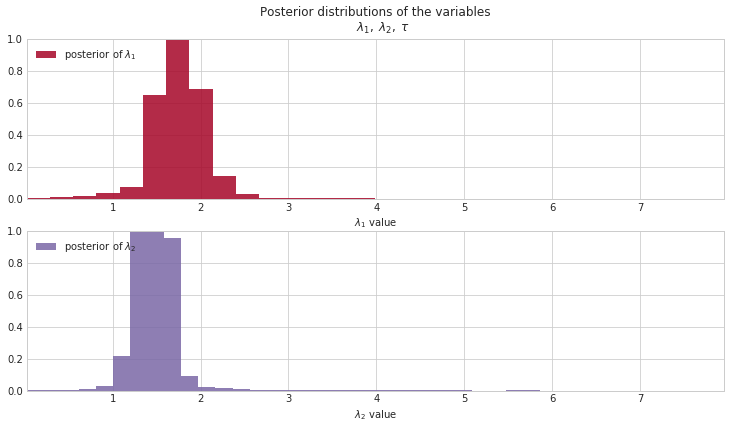

In [14]:
figsize(12.5, 10)
#histogram of the samples:
xlim = [min(lambda_1_samples.min(), lambda_2_samples.min()), max(lambda_1_samples.max(), lambda_2_samples.max())]
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(xlim)
# plt.ylim([0, .75])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim(xlim)
# plt.ylim([0, .5])
plt.xlabel("$\lambda_2$ value")

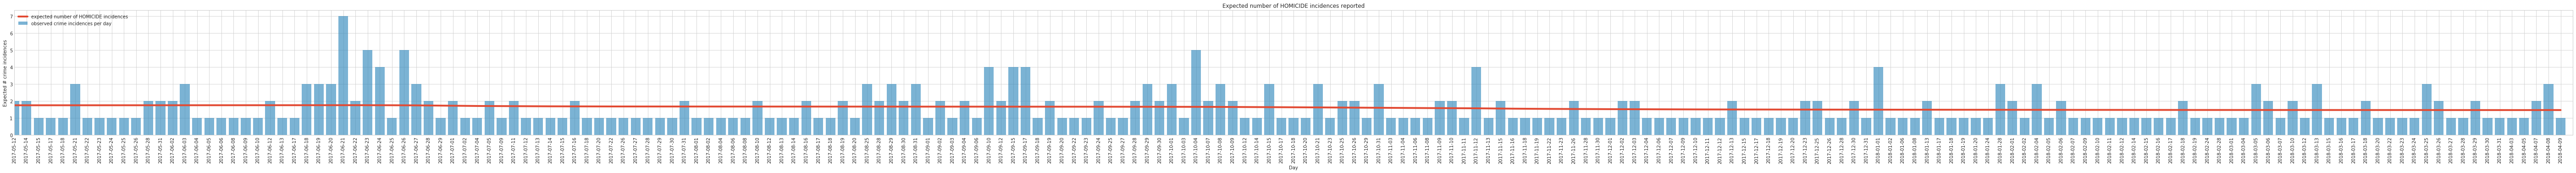

In [15]:
figsize(100, 5)
n_count_data = len(count_data)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_crime_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "crime incidence count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "crime incidence count".
    expected_crime_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_crime_per_day, lw=4, color="#E24A33",
         label="expected number of HOMICIDE incidences")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # crime incidences")
plt.title("Expected number of HOMICIDE incidences reported")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed crime incidences per day")
plt.xticks(np.arange(len(count_data)), count_data.index, rotation='vertical')
plt.legend(loc="upper left");

## Murder

In [16]:
lambda_1_samples, lambda_2_samples, tau_samples, count_data, n_count_data = by_crime_type('MURDER')

Creating model..
Running MCMC..


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2_log__, lambda_1_log__]
>Metropolis: [tau]
100%|██████████| 40000/40000 [00:38<00:00, 1049.56it/s]
The number of effective samples is smaller than 10% for some parameters.


% Decrease of crime: 0.41920001394562656


/home/hadrian/.local/share/virtualenvs/Bantay-Krimen-Analysis-RDt4h6uW/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\lambda_2$ value')

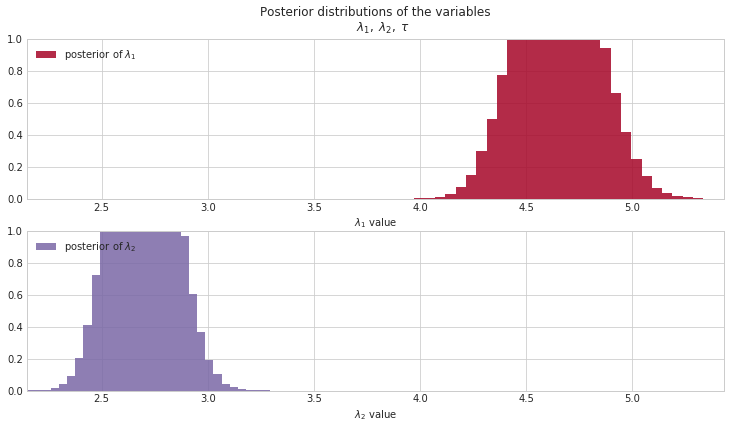

In [17]:
figsize(12.5, 10)
#histogram of the samples:
xlim = [min(lambda_1_samples.min(), lambda_2_samples.min()), max(lambda_1_samples.max(), lambda_2_samples.max())]
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(xlim)
# plt.ylim([0, .75])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim(xlim)
# plt.ylim([0, .5])
plt.xlabel("$\lambda_2$ value")

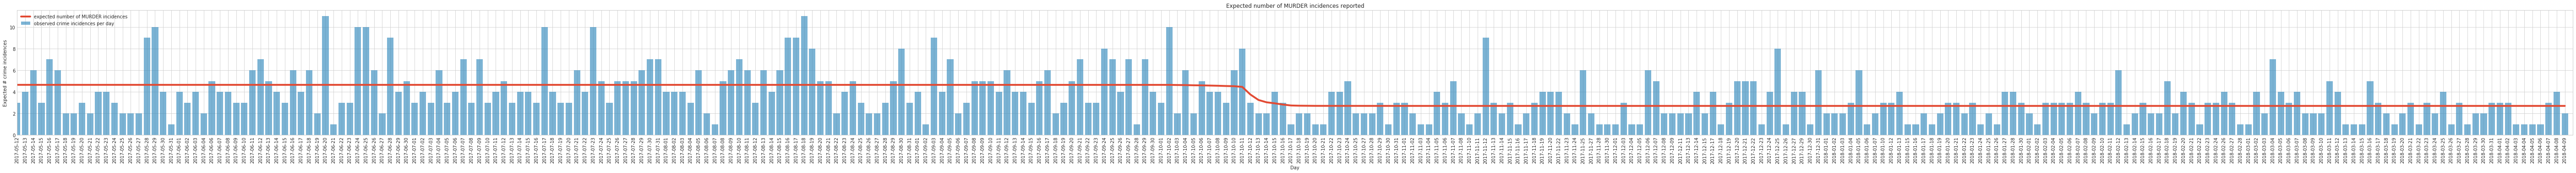

In [18]:
figsize(100, 5)
n_count_data = len(count_data)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_crime_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "crime incidence count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "crime incidence count".
    expected_crime_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_crime_per_day, lw=4, color="#E24A33",
         label="expected number of MURDER incidences")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # crime incidences")
plt.title("Expected number of MURDER incidences reported")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed crime incidences per day")
plt.xticks(np.arange(len(count_data)), count_data.index, rotation='vertical')
plt.legend(loc="upper left");

## Theft Incidences

In [19]:
lambda_1_samples, lambda_2_samples, tau_samples, count_data, n_count_data = by_crime_type(
    'THEFT')

Creating model..
Running MCMC..


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2_log__, lambda_1_log__]
>Metropolis: [tau]
100%|██████████| 40000/40000 [00:37<00:00, 1060.16it/s]
The number of effective samples is smaller than 10% for some parameters.


% Decrease of crime: 0.19410469866497804


/home/hadrian/.local/share/virtualenvs/Bantay-Krimen-Analysis-RDt4h6uW/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\lambda_2$ value')

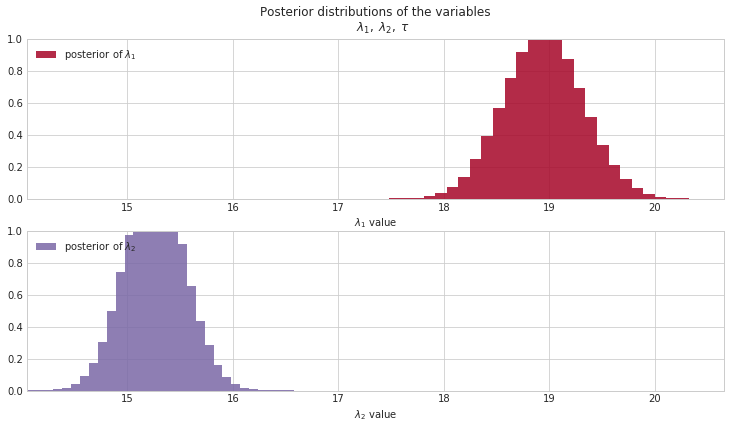

In [20]:
figsize(12.5, 10)
#histogram of the samples:
xlim = [min(lambda_1_samples.min(), lambda_2_samples.min()), max(lambda_1_samples.max(), lambda_2_samples.max())]
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(xlim)
# plt.ylim([0, .75])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim(xlim)
# plt.ylim([0, .5])
plt.xlabel("$\lambda_2$ value")

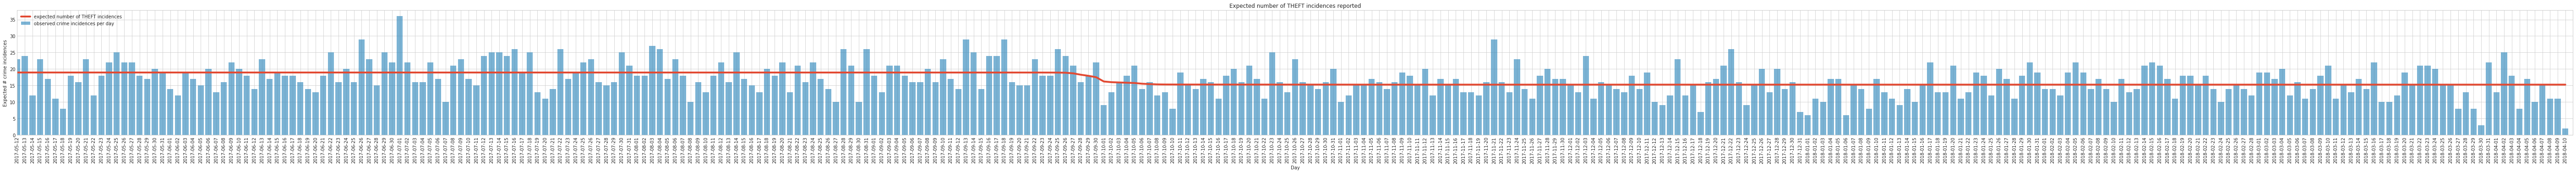

In [21]:
figsize(100, 5)
n_count_data = len(count_data)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_crime_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "crime incidence count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "crime incidence count".
    expected_crime_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_crime_per_day, lw=4, color="#E24A33",
         label="expected number of THEFT incidences")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # crime incidences")
plt.title("Expected number of THEFT incidences reported")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed crime incidences per day")
plt.xticks(np.arange(len(count_data)), count_data.index, rotation='vertical')
plt.legend(loc="upper left");

## Robbery

In [22]:
lambda_1_samples, lambda_2_samples, tau_samples, count_data, n_count_data = by_crime_type('ROBBERY')

Creating model..
Running MCMC..


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2_log__, lambda_1_log__]
>Metropolis: [tau]
100%|██████████| 40000/40000 [00:40<00:00, 992.30it/s]
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 182 divergences after tuning. Increase `target_accept` or reparameterize.
There were 440 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6339518565999942, but should be close to 0.8. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


% Decrease of crime: 0.22705902640158093


/home/hadrian/.local/share/virtualenvs/Bantay-Krimen-Analysis-RDt4h6uW/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\lambda_2$ value')

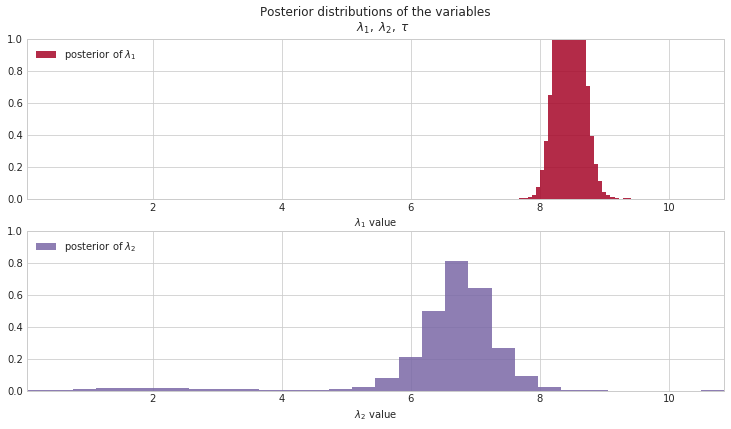

In [23]:
figsize(12.5, 10)
#histogram of the samples:
xlim = [min(lambda_1_samples.min(), lambda_2_samples.min()), max(lambda_1_samples.max(), lambda_2_samples.max())]
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(xlim)
# plt.ylim([0, .75])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim(xlim)
# plt.ylim([0, .5])
plt.xlabel("$\lambda_2$ value")

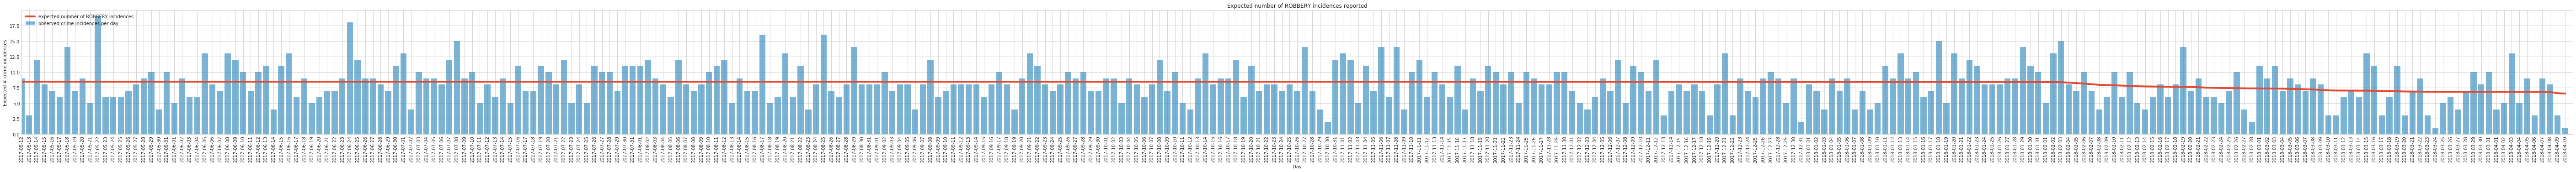

In [24]:
figsize(100, 5)
n_count_data = len(count_data)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_crime_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "crime incidence count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "crime incidence count".
    expected_crime_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_crime_per_day, lw=4, color="#E24A33",
         label="expected number of ROBBERY incidences")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # crime incidences")
plt.title("Expected number of ROBBERY incidences reported")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed crime incidences per day")
plt.xticks(np.arange(len(count_data)), count_data.index, rotation='vertical')
plt.legend(loc="upper left");

## Drug Related Incident (RA 9165)

In [25]:
lambda_1_samples, lambda_2_samples, tau_samples, count_data, n_count_data = by_crime_type(
    'Drug Related Incident (RA 9165)')

Creating model..
Running MCMC..


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2_log__, lambda_1_log__]
>Metropolis: [tau]
100%|██████████| 40000/40000 [00:38<00:00, 1050.47it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


% Decrease of crime: 0.3758852486314932


/home/hadrian/.local/share/virtualenvs/Bantay-Krimen-Analysis-RDt4h6uW/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\lambda_2$ value')

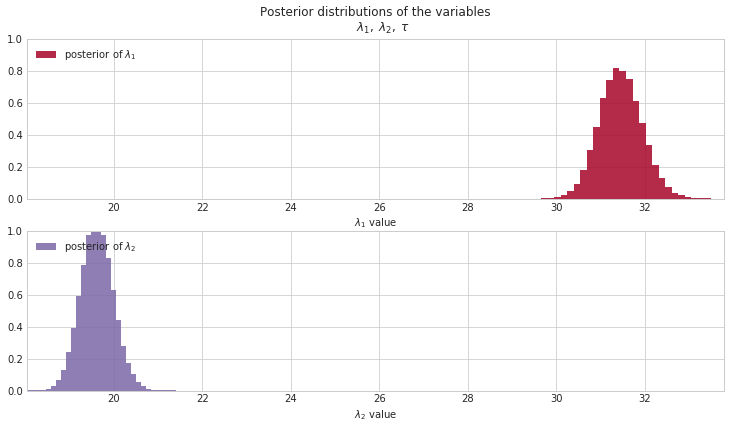

In [26]:
figsize(12.5, 10)
#histogram of the samples:
xlim = [min(lambda_1_samples.min(), lambda_2_samples.min()), max(lambda_1_samples.max(), lambda_2_samples.max())]
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(xlim)
# plt.ylim([0, .75])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim(xlim)
# plt.ylim([0, .5])
plt.xlabel("$\lambda_2$ value")

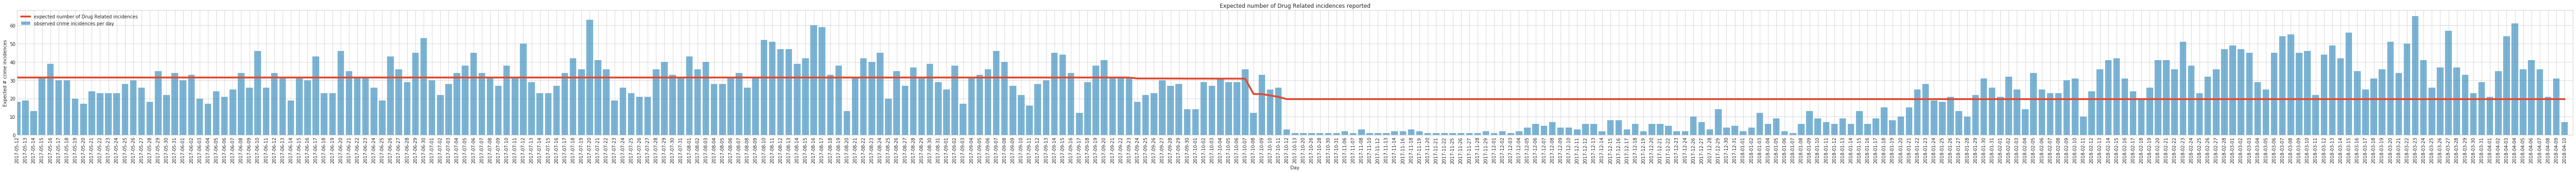

In [27]:
figsize(100, 5)
n_count_data = len(count_data)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_crime_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "crime incidence count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "crime incidence count".
    expected_crime_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_crime_per_day, lw=4, color="#E24A33",
         label="expected number of Drug Related incidences")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # crime incidences")
plt.title("Expected number of Drug Related incidences reported")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed crime incidences per day")
plt.xticks(np.arange(len(count_data)), count_data.index, rotation='vertical')
plt.legend(loc="upper left");

## RAPE (Art. 266-A RC & R.A.8353)

In [28]:
lambda_1_samples, lambda_2_samples, tau_samples, count_data, n_count_data = by_crime_type(
    'RAPE (Art. 266-A RC & R.A.8353)')

Creating model..
Running MCMC..


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2_log__, lambda_1_log__]
>Metropolis: [tau]
100%|██████████| 40000/40000 [00:43<00:00, 925.68it/s]
There were 1768 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7079488058869575, but should be close to 0.8. Try to increase the number of tuning steps.
There were 521 divergences after tuning. Increase `target_accept` or reparameterize.
There were 592 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8859048953088324, but should be close to 0.8. Try to increase the number of tuning steps.
There were 32058 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.0028797739978763588, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effe

% Decrease of crime: 0.2823360809511065


/home/hadrian/.local/share/virtualenvs/Bantay-Krimen-Analysis-RDt4h6uW/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\lambda_2$ value')

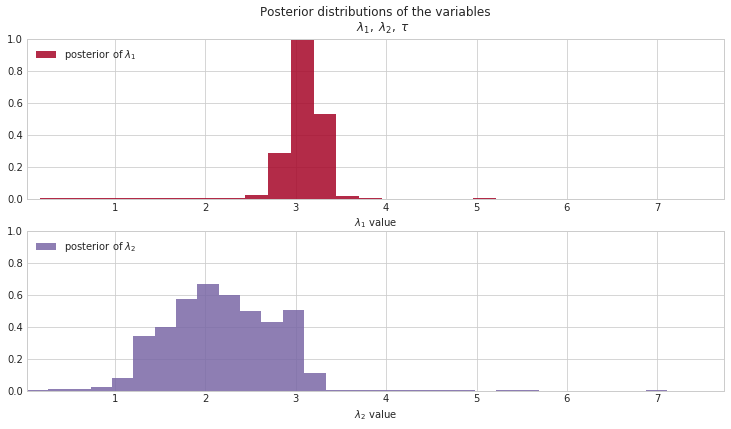

In [29]:
figsize(12.5, 10)
#histogram of the samples:
xlim = [min(lambda_1_samples.min(), lambda_2_samples.min()), max(lambda_1_samples.max(), lambda_2_samples.max())]
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(xlim)
# plt.ylim([0, .75])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim(xlim)
# plt.ylim([0, .5])
plt.xlabel("$\lambda_2$ value")

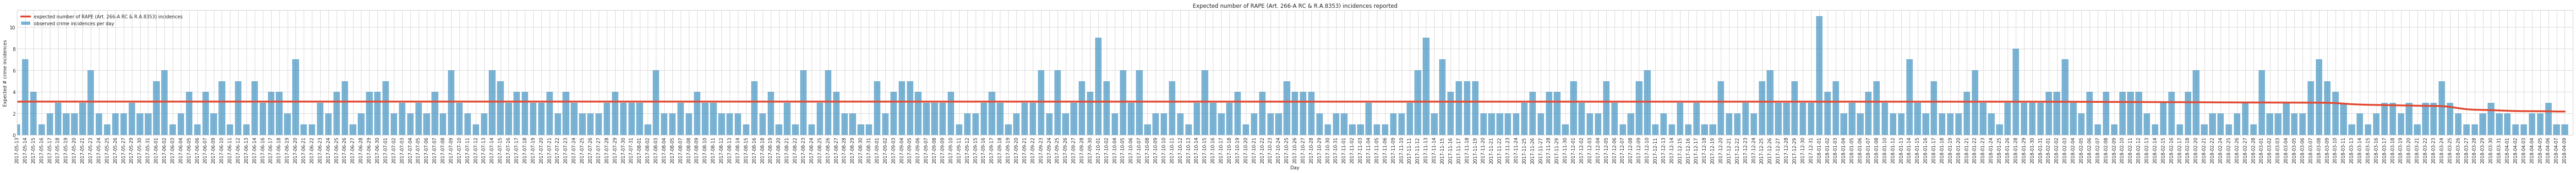

In [30]:
figsize(100, 5)
n_count_data = len(count_data)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_crime_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "crime incidence count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "crime incidence count".
    expected_crime_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_crime_per_day, lw=4, color="#E24A33",
         label="expected number of RAPE (Art. 266-A RC & R.A.8353) incidences")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # crime incidences")
plt.title("Expected number of RAPE (Art. 266-A RC & R.A.8353) incidences reported")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed crime incidences per day")
plt.xticks(np.arange(len(count_data)), count_data.index, rotation='vertical')
plt.legend(loc="upper left");

## Vehicular Traffic Accident

In [31]:
lambda_1_samples, lambda_2_samples, tau_samples, count_data, n_count_data = by_crime_type(
    'Vehicular Traffic Accident')

Creating model..
Running MCMC..


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2_log__, lambda_1_log__]
>Metropolis: [tau]
100%|██████████| 40000/40000 [00:38<00:00, 1040.40it/s]
The number of effective samples is smaller than 10% for some parameters.


% Decrease of crime: 0.12713457078537915


/home/hadrian/.local/share/virtualenvs/Bantay-Krimen-Analysis-RDt4h6uW/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\lambda_2$ value')

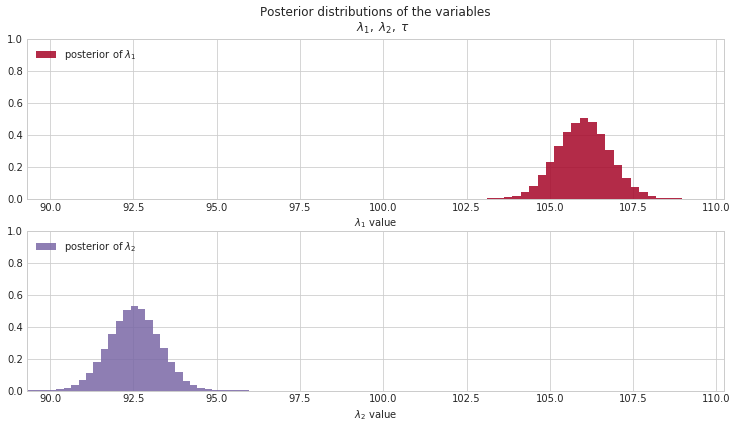

In [32]:
figsize(12.5, 10)
#histogram of the samples:
xlim = [min(lambda_1_samples.min(), lambda_2_samples.min()), max(lambda_1_samples.max(), lambda_2_samples.max())]
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(xlim)
# plt.ylim([0, .75])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim(xlim)
# plt.ylim([0, .5])
plt.xlabel("$\lambda_2$ value")

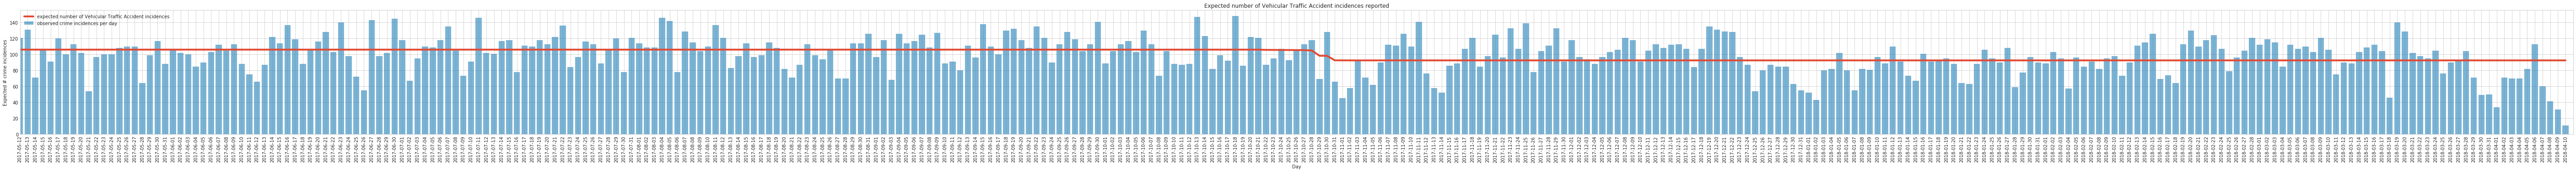

In [33]:
figsize(100, 5)
n_count_data = len(count_data)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_crime_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "crime incidence count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "crime incidence count".
    expected_crime_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_crime_per_day, lw=4, color="#E24A33",
         label="expected number of Vehicular Traffic Accident incidences")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # crime incidences")
plt.title("Expected number of Vehicular Traffic Accident incidences reported")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed crime incidences per day")
plt.xticks(np.arange(len(count_data)), count_data.index, rotation='vertical')
plt.legend(loc="upper left");

## Physical Injuries

In [34]:
lambda_1_samples, lambda_2_samples, tau_samples, count_data, n_count_data = by_crime_type(
    'PHYSICAL INJURIES')

Creating model..
Running MCMC..


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2_log__, lambda_1_log__]
>Metropolis: [tau]
100%|██████████| 40000/40000 [00:45<00:00, 872.06it/s]
The acceptance probability does not match the target. It is 0.7020317388928435, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


% Decrease of crime: 0.34567262975482116


/home/hadrian/.local/share/virtualenvs/Bantay-Krimen-Analysis-RDt4h6uW/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\lambda_2$ value')

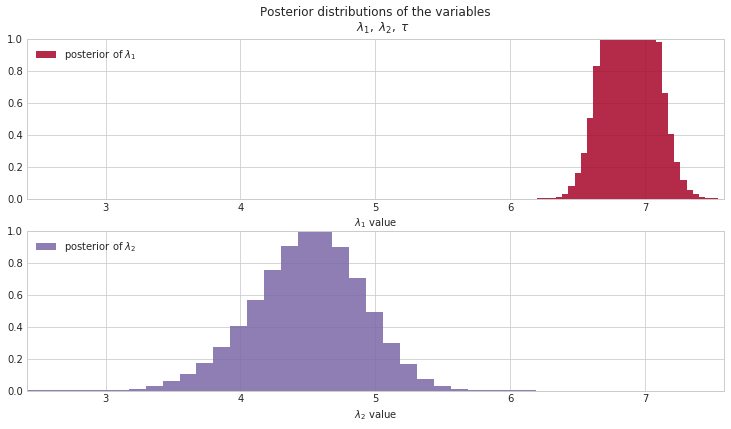

In [35]:
figsize(12.5, 10)
#histogram of the samples:
xlim = [min(lambda_1_samples.min(), lambda_2_samples.min()), max(lambda_1_samples.max(), lambda_2_samples.max())]
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(xlim)
# plt.ylim([0, .75])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim(xlim)
# plt.ylim([0, .5])
plt.xlabel("$\lambda_2$ value")

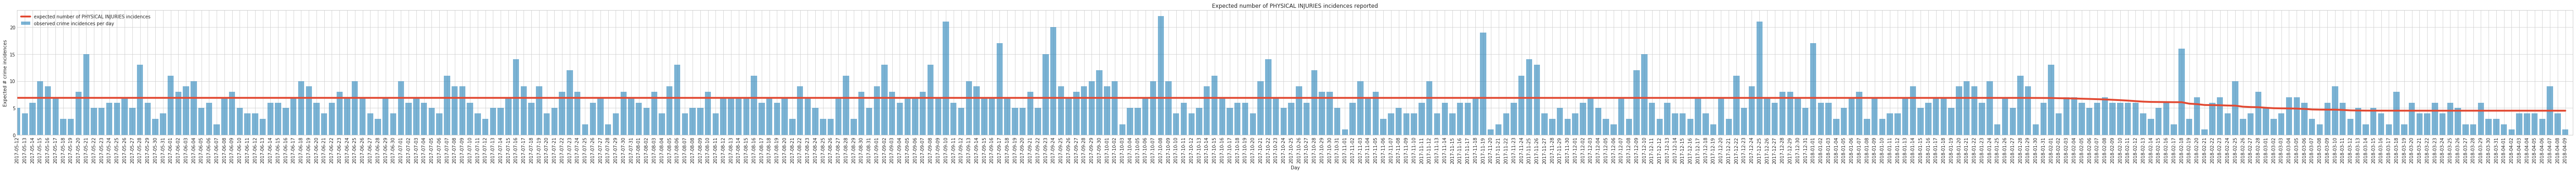

In [36]:
figsize(100, 5)
n_count_data = len(count_data)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_crime_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "crime incidence count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "crime incidence count".
    expected_crime_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_crime_per_day, lw=4, color="#E24A33",
         label="expected number of PHYSICAL INJURIES incidences")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # crime incidences")
plt.title("Expected number of PHYSICAL INJURIES incidences reported")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed crime incidences per day")
plt.xticks(np.arange(len(count_data)), count_data.index, rotation='vertical')
plt.legend(loc="upper left");

## Insights

1. Sudden decrease in overall crime incidence reports for NCR are attributed to the suspension of Oplan Tokhang on Oct. 12, 2017.
2. However, sudden consistent 10-25% decrease in crime incidence reports happened during the end of October for types of  criminal activities, specifically Drugs Incidence, Murder, and Theft. For Homicide, Robbery, Physical Injuries, and Rape cases, it can be observed that these have a natural decreasing trend. Even Vehicular Traffic Accident reports are sharply reduced by 10% at the end of October.

## Opinions and Next Steps
1. What can possibly explain the sudden drop in crime incidence reports for certain types of activies?
2. Conduct Spatiotemporal analysis to factor in spatial distributions.